In [1]:
pip install ucimlrepo

  Obtaining dependency information for ucimlrepo from https://files.pythonhosted.org/packages/3b/07/1252560194df2b4fad1cb3c46081b948331c63eb1bb0b97620d508d12a53/ucimlrepo-0.0.7-py3-none-any.whl.metadata
Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

In [6]:
import pandas as pd
from ucimlrepo import fetch_ucirepo

# Load dataset from UCI repo
heart = fetch_ucirepo(id=45)   # Heart Disease dataset

# Combine features + target
X = heart.data.features
y = heart.data.targets
df = pd.concat([X, y], axis=1)

print(df.shape)
df.head()


(303, 14)


,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num
0,63,1,1,145,233,1,2,150,0,2.3,3,0.0,6.0,0
1,67,1,4,160,286,0,2,108,1,1.5,2,3.0,3.0,2
2,67,1,4,120,229,0,2,129,1,2.6,2,2.0,7.0,1
3,37,1,3,130,250,0,0,187,0,3.5,3,0.0,3.0,0
4,41,0,2,130,204,0,2,172,0,1.4,1,0.0,3.0,0


In [8]:
import numpy as np
from sklearn.impute import SimpleImputer

# Replace '?' with NaN
df = df.replace('?', np.nan)

# Detect target column
target_col = None
for cand in ['target', 'num', 'diagnosis']:
    if cand in df.columns:
        target_col = cand
        break
if target_col is None:
    target_col = df.columns[-1]   # fallback: last column

print("Using target column:", target_col)

# Separate features and target
X = df.drop(columns=[target_col])
y = df[target_col]

# Identify numeric and categorical columns
num_cols = X.select_dtypes(include=[np.number]).columns
cat_cols = X.select_dtypes(exclude=[np.number]).columns

# Imputers
num_imputer = SimpleImputer(strategy="median")
cat_imputer = SimpleImputer(strategy="most_frequent")

if len(num_cols) > 0:
    X[num_cols] = num_imputer.fit_transform(X[num_cols])
if len(cat_cols) > 0:
    X[cat_cols] = cat_imputer.fit_transform(X[cat_cols])

# Recombine
df_clean = pd.concat([X, y], axis=1)

print("Missing values after imputation:\n", df_clean.isna().sum().sort_values(ascending=False))
df_clean.head()


Using target column: num
Missing values after imputation:
 age         0
sex         0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalach     0
exang       0
oldpeak     0
slope       0
ca          0
thal        0
num         0
dtype: int64


,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num
0,63.0,1.0,1.0,145.0,233.0,1.0,2.0,150.0,0.0,2.3,3.0,0.0,6.0,0
1,67.0,1.0,4.0,160.0,286.0,0.0,2.0,108.0,1.0,1.5,2.0,3.0,3.0,2
2,67.0,1.0,4.0,120.0,229.0,0.0,2.0,129.0,1.0,2.6,2.0,2.0,7.0,1
3,37.0,1.0,3.0,130.0,250.0,0.0,0.0,187.0,0.0,3.5,3.0,0.0,3.0,0
4,41.0,0.0,2.0,130.0,204.0,0.0,2.0,172.0,0.0,1.4,1.0,0.0,3.0,0


In [14]:
df_clean.to_csv(r"C:\Users\Eman\Downloads\HeartDiseaseProject\data\heart_disease_cleaned.csv", index=False)

In [9]:
from sklearn.preprocessing import OneHotEncoder

# Copy clean dataset (from previous step)
X_encoded = X.copy()

# One-hot encode categorical columns
if len(cat_cols) > 0:
    ohe = OneHotEncoder(drop=None, handle_unknown="ignore", sparse=False)
    X_ohe = ohe.fit_transform(X[cat_cols])
    ohe_cols = ohe.get_feature_names_out(cat_cols)
    
    # Replace categorical cols with their encoded version
    X_encoded = pd.concat([
        X[num_cols].reset_index(drop=True),
        pd.DataFrame(X_ohe, columns=ohe_cols, index=X.index)
    ], axis=1)
else:
    print("No categorical columns found — skipping encoding.")

# Recombine with target
df_encoded = pd.concat([X_encoded, y.reset_index(drop=True)], axis=1)

print("Shape after encoding:", df_encoded.shape)
df_encoded.head()


No categorical columns found — skipping encoding.
Shape after encoding: (303, 14)


,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num
0,63.0,1.0,1.0,145.0,233.0,1.0,2.0,150.0,0.0,2.3,3.0,0.0,6.0,0
1,67.0,1.0,4.0,160.0,286.0,0.0,2.0,108.0,1.0,1.5,2.0,3.0,3.0,2
2,67.0,1.0,4.0,120.0,229.0,0.0,2.0,129.0,1.0,2.6,2.0,2.0,7.0,1
3,37.0,1.0,3.0,130.0,250.0,0.0,0.0,187.0,0.0,3.5,3.0,0.0,3.0,0
4,41.0,0.0,2.0,130.0,204.0,0.0,2.0,172.0,0.0,1.4,1.0,0.0,3.0,0


In [10]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# Choose scaler: 'standard' or 'minmax'
scaler_choice = "standard"   # change to "minmax" if you prefer MinMaxScaler

if scaler_choice == "standard":
    scaler = StandardScaler()
else:
    scaler = MinMaxScaler()

# Fit-transform numeric columns
X_scaled = X_encoded.copy()
X_scaled[num_cols] = scaler.fit_transform(X_encoded[num_cols])

# Recombine with target
df_scaled = pd.concat([X_scaled, y.reset_index(drop=True)], axis=1)

print("Shape after scaling:", df_scaled.shape)
df_scaled.head()


Shape after scaling: (303, 14)


,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num
0,0.948726,0.686202,-2.251775,0.757525,-0.264900,2.394438,1.016684,0.017197,-0.696631,1.087338,2.274579,-0.711131,0.660004,0
1,1.392002,0.686202,0.877985,1.611220,0.760415,-0.417635,1.016684,-1.821905,1.435481,0.397182,0.649113,2.504881,-0.890238,2
2,1.392002,0.686202,0.877985,-0.665300,-0.342283,-0.417635,1.016684,-0.902354,1.435481,1.346147,0.649113,1.432877,1.176752,1
3,-1.932564,0.686202,-0.165268,-0.096170,0.063974,-0.417635,-0.996749,1.637359,-0.696631,2.122573,2.274579,-0.711131,-0.890238,0
4,-1.489288,-1.457296,-1.208521,-0.096170,-0.825922,-0.417635,1.016684,0.980537,-0.696631,0.310912,-0.976352,-0.711131,-0.890238,0


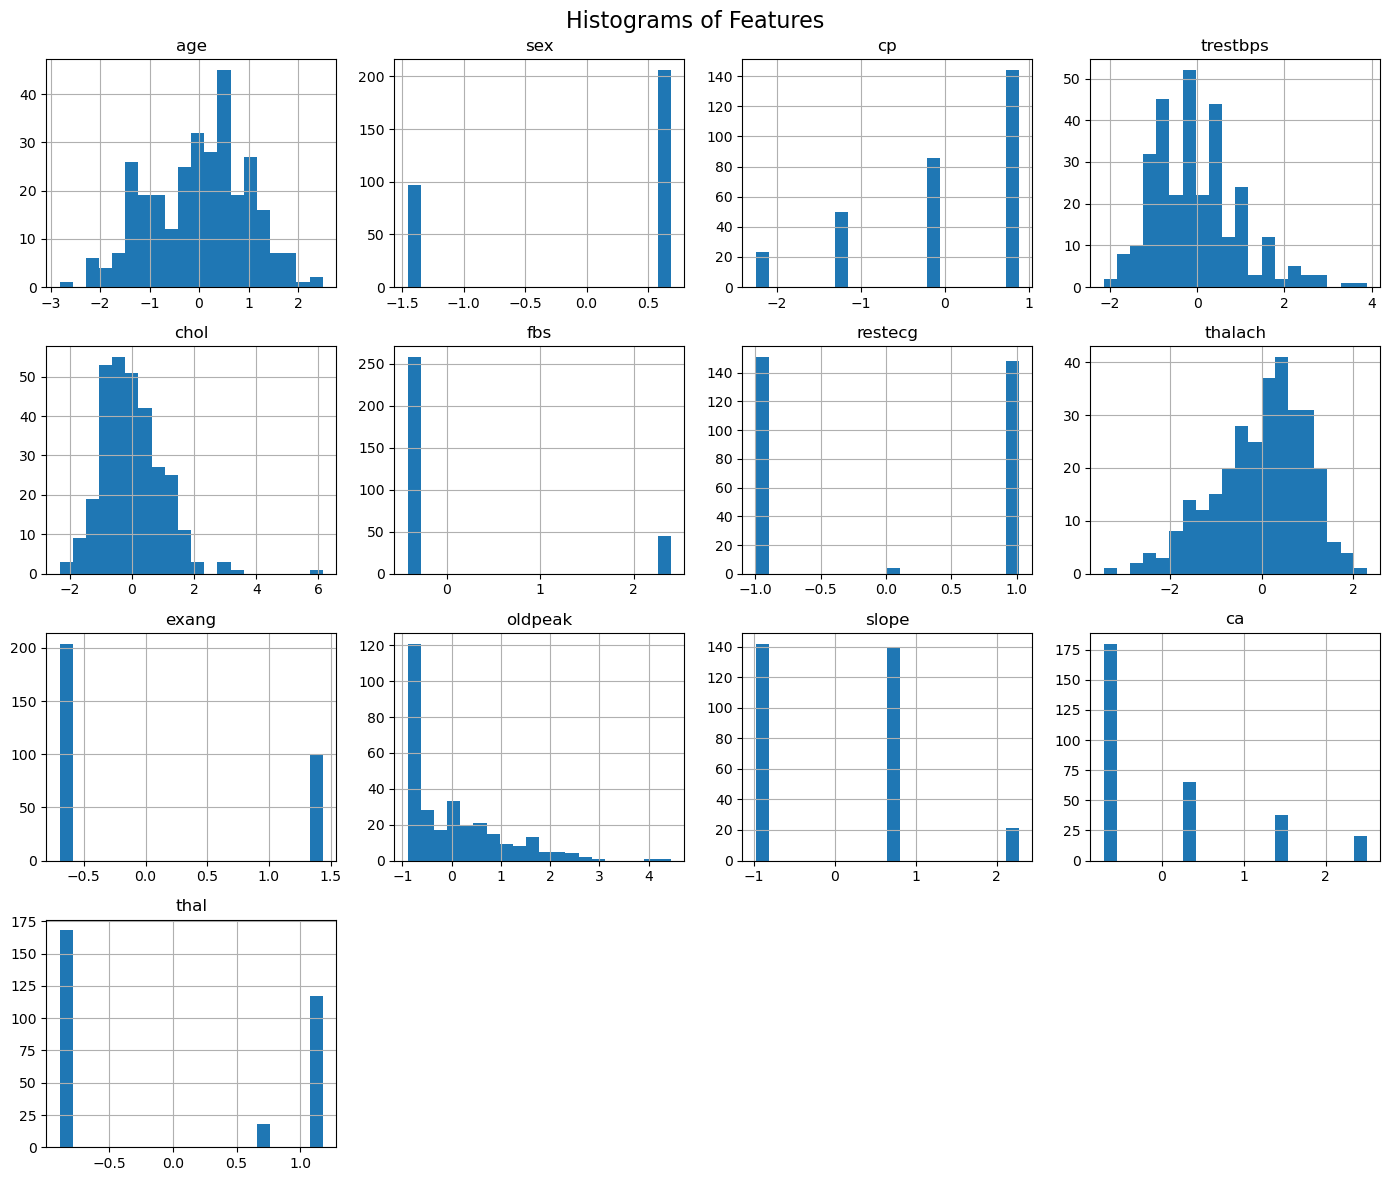

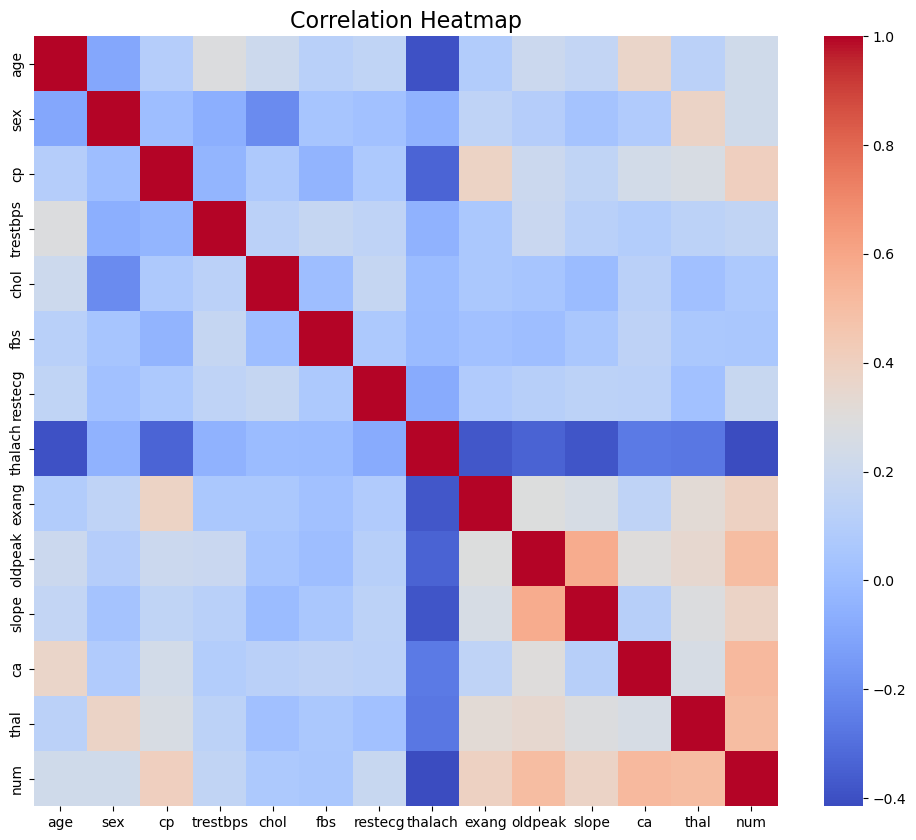

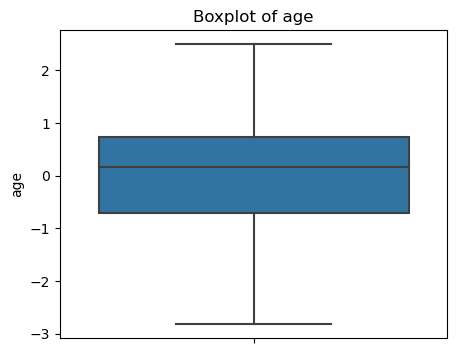

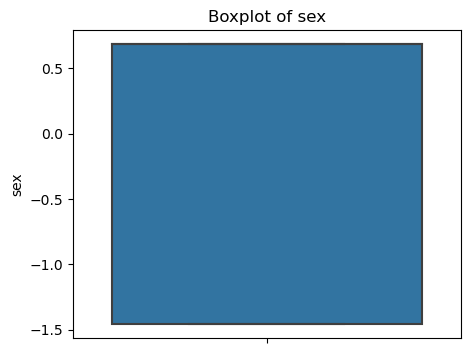

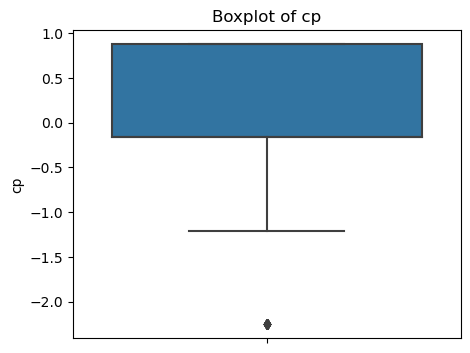

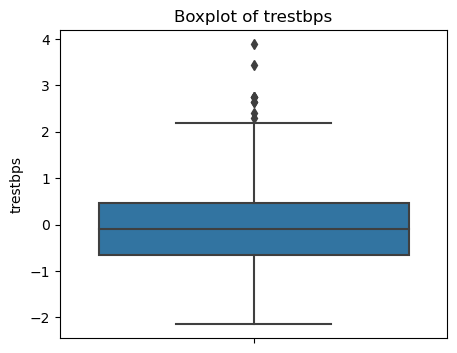

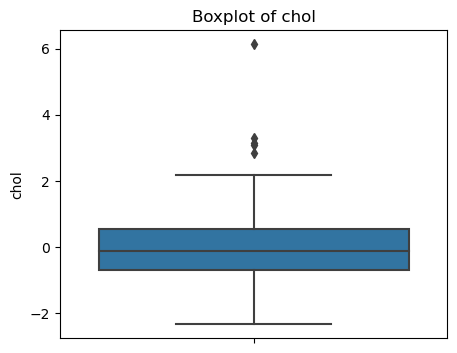

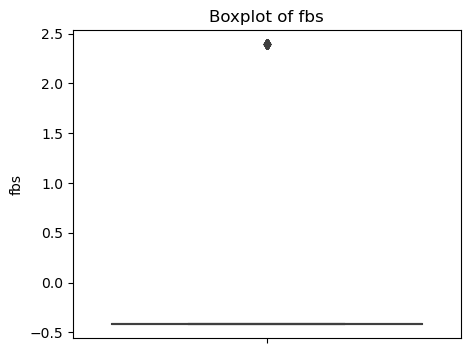

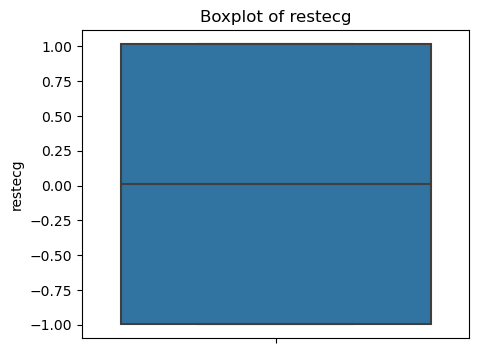

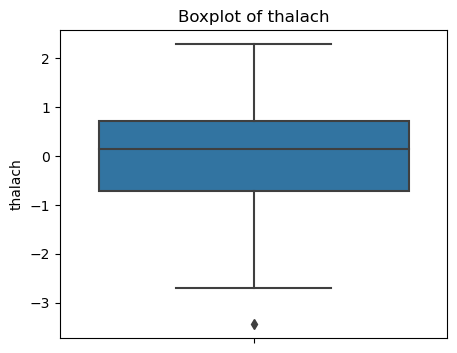

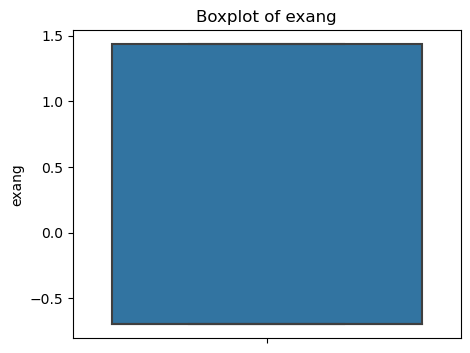

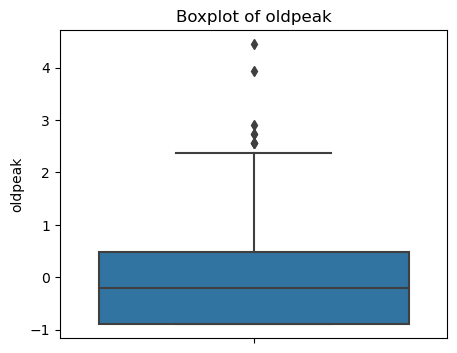

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

# Work on the cleaned/scaled dataframe
eda_df = df_scaled.copy()

# --- Histograms for numeric features ---
eda_df.drop(columns=[target_col]).hist(figsize=(14, 12), bins=20)
plt.suptitle("Histograms of Features", fontsize=16)
plt.tight_layout()
plt.show()

# --- Correlation Heatmap ---
plt.figure(figsize=(12, 10))
corr = eda_df.corr()
sns.heatmap(corr, annot=False, cmap="coolwarm", cbar=True)
plt.title("Correlation Heatmap", fontsize=16)
plt.show()

# --- Boxplots (first 10 features) ---
num_cols_full = eda_df.drop(columns=[target_col]).select_dtypes(include=['float64','int64']).columns.tolist()
for col in num_cols_full[:10]:
    plt.figure(figsize=(5, 4))
    sns.boxplot(y=eda_df[col])
    plt.title(f"Boxplot of {col}")
    plt.show()


In [13]:
df_scaled.to_csv(r"C:\Users\Eman\Downloads\HeartDiseaseProject\data\heart_disease_model_ready.csv", index=False)